In [8]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Define comb creation functions
def comb_x(cps1):
  comb_x_values = np.fft.fftfreq(n = int(cps1['time'] * cps1['sample_rate']), d = 1 / cps1['sample_rate'])
  return comb_x_values

def calculate_h(cps2, comb_x_values_i):
  path_length = 100e-3
  speed_of_light = 3e8
  refractive_index = cps2['n_0']
  absorption_coefficient = cps2['alpha_0']
  refractive_index_transformed = refractive_index + 0.1 * np.sin(comb_x_values_i*2*np.pi)
  absorption_coeffient_transoformed = absorption_coefficient * np.exp(-comb_x_values_i / 1.5e14)
  H_absorption_value = np.exp(-absorption_coeffient_transoformed * path_length)
  H_phase_value = np.exp(-1j * 2 * np.pi * comb_x_values_i * (refractive_index_transformed - 1) * path_length / speed_of_light)
  H_value = H_absorption_value * H_phase_value
  return H_value

def comb_y(cps3, comb_x_values_j):
  # Identify the basic independent variable points representing the entire wave, known as samples
  number_of_samples = int(cps3['time'] * cps3['sample_rate'])
  sample_set = np.zeros(number_of_samples) # Unit is 'number of samples,' representing total amount of points present in the grand train

  # Addresses pulses in the wave
  number_of_pulses_without_reference_to_samples = int(cps3['time'] * cps3['rep_rate'])
  amount_of_samples_coincident_with_pulses = int(cps3['pulse_duration'] * cps3['sample_rate']) # in just one pulse

  # Identify the time points (with units of seconds, not to be confused with sample points) at which pulses start
  pulse_drift_black_box = np.linspace(0,
                                      cps3['drift'] / cps3['rep_rate'],
                                      number_of_pulses_without_reference_to_samples) * np.exp(np.linspace(0,
                                                                                                          100 * cps3['drift'],
                                                                                                          number_of_pulses_without_reference_to_samples))
  pulse_times_noise_black_box = np.random.normal(loc = np.arange(number_of_pulses_without_reference_to_samples) / cps3['rep_rate'],
                                                 scale = cps3['jitter'] / cps3['rep_rate'],
                                                 size = number_of_pulses_without_reference_to_samples)

  # Synthesize to determine pulse time start points
  actual_pulse_time_start_points = np.add(pulse_times_noise_black_box,
                                          pulse_drift_black_box)

  # Wherever sample points are coincident with pulse points, set those sample values to one
  for actual_pulse_time_start_point in actual_pulse_time_start_points:
    starting_sample = int(actual_pulse_time_start_point * cps3['sample_rate'])
    if starting_sample + amount_of_samples_coincident_with_pulses < number_of_samples:
      sample_set[starting_sample:starting_sample + amount_of_samples_coincident_with_pulses] = 1

  # Add noise to all points of the sample train
  sample_set += cps3['noise'] * np.random.normal(size = number_of_samples)

  # Perform Fourier transform on the sample train to identify ampltidues of constituent frequencies
  fourier_amplitudes = np.fft.fft(sample_set)

  # Modify spectrum according to H parameter
  h_parameter = calculate_h(cps3, comb_x_values_j)
  final_amplitudes = fourier_amplitudes * h_parameter
  return np.abs(final_amplitudes)

Text(0.5, 0, 'Frequency (cm⁻¹)')

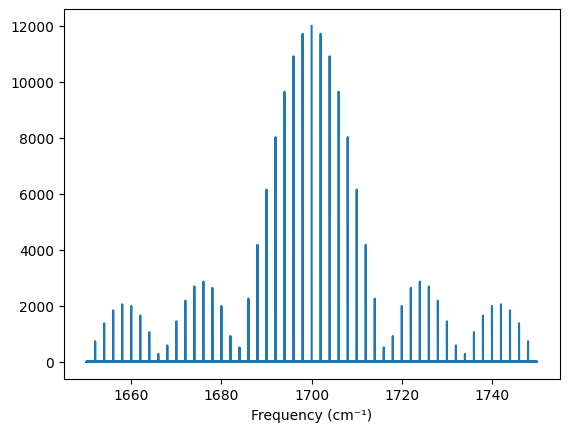

In [25]:
### Set desired peak parameters

# Main parameters
peak_spacing = 2
broadness_of_comb = 1
horizontal_comb_shift = 1700
noise_of_pulse = 0.01

# Other parameters
drift_comb = 0.000  # Jack set this parameter to 0.010
jitter_comb = 0.000
refractive_index_comb = 000.0
absorption_coefficient_comb = 0.0
total_experiment_duration = 1e3


# Apply parameters
comb_parameters = {'rep_rate': peak_spacing,
                   'pulse_duration': 60e-3 * (1 / broadness_of_comb),
                   'time': total_experiment_duration,
                   'sample_rate': 100e0 * broadness_of_comb,
                   'noise': noise_of_pulse,
                   'jitter': jitter_comb,
                   'drift': drift_comb,
                   'n_0': refractive_index_comb,
                   'alpha_0': absorption_coefficient_comb}

# Plot comb
figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)
comb_x_axis = comb_x(comb_parameters)
comb_y_axis = comb_y(comb_parameters, comb_x_axis)
axes.plot(comb_x_axis + horizontal_comb_shift, comb_y_axis)
axes.set_xlabel(u'Frequency (cm\u207B\u00B9)')